はじめに

物理学の実験においては、事前に測定値を予測することが可能な様々な理論式が知られています。理論式を検証するために実験を行うこともあれば、理論式に合わない実験結果を説明するために新たな理論が提唱されることもあります。ここではラザフォード散乱の式を例にとり、理論式を用いた予想と検証を行います。

実験前から結果を予想して議論するために、ダミーのデータを生成できるようになっています。データを取得したら置き換えることで、実際のデータに即した議論ができます。

In [110]:
#スクリプト実行に必要なパッケージ。
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson,norm

In [3]:
#実験データなど、Googleドライブにあるファイルにアクセスしたい場合に実行する。自分のアカウントで要認証。ダミーデータで取り組む場合は実行不要
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


実験装置のキャリブレーション・測定

この実験ではα線源、金及びアルミ薄膜、SSDを用います。それぞれの性能の公称値は以下です。
*   線源：　2 MBq (1 Bq = 1 event/sec)
*   金箔：　1 μm, 19.3g/cm^3
*   アルミ箔：　10 μm, 2.69 g/cm^3

これらの公称値を参考にしつつ、装置のキャリブレーションを行います。

まずはスペクトルのエネルギーとチャンネルの関係を調べます。パルス波の大きさを変えながら、チャンネルがどのように変化するか調べ、**パルス波の大きさが0の時のチャンネルを0 MeV相当のエネルギーとして求めます**。

In [110]:
#シミュレーション用ダミー
A=723 #仮の中心値
dA=3 #仮の幅
off=5 #仮のオフセット

pulsar100 = np.random.normal(A+off, dA, 5000)
pulsar100, x = np.histogram(pulsar100, range=(0, 1024), bins=1024)
pulsar90 = np.random.normal(A*0.9+off, dA, 5000)
pulsar90, x = np.histogram(pulsar90, range=(0, 1024), bins=1024)
pulsar80 = np.random.normal(A*0.8+off, dA, 5000)
pulsar80, x = np.histogram(pulsar80, range=(0, 1024), bins=1024)
pulsar70 = np.random.normal(A*0.7+off, dA, 5000)
pulsar70, x = np.histogram(pulsar70, range=(0, 1024), bins=1024)
pulsar60 = np.random.normal(A*0.6+off, dA, 5000)
pulsar60, x = np.histogram(pulsar60, range=(0, 1024), bins=1024)
pulsar_list=[pulsar100, pulsar90, pulsar80, pulsar70, pulsar60]
pulsar = pulsar100 + pulsar90 + pulsar80 + pulsar70 + pulsar60

means = np.array([1,0.9,0.8,0.7,0.6])
means = A*means


print('check1:',pulsar100,pulsar100.size)
print('check2:',pulsar,pulsar.size,means)

check1: [0 0 0 ... 0 0 0] 1024
check2: [0 0 0 ... 0 0 0] 1024 [723.  650.7 578.4 506.1 433.8]


In [5]:
#実データ用。パスと名前は適宜書き換えること
pulsar100 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/pulse2p4.csv', skip_footer=6)
pulsar90 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/pulse2p2.csv', skip_footer=6)
pulsar80 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/pulse2p0.csv', skip_footer=6)
pulsar70 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/pulse1p8.csv', skip_footer=6)
pulsar60 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/pulse1p6.csv', skip_footer=6)
pulsar50 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/pulse1p4.csv', skip_footer=6)
pulsar_list=[pulsar100, pulsar90, pulsar80, pulsar70, pulsar60, pulsar50]
pulsar = pulsar100 + pulsar90 + pulsar80 + pulsar70 + pulsar60 + pulsar50

means = np.array([2.4,2.2,2.0,1.8,1.6,1.4])
means *= 765/2.4
dA=50 #仮の幅

print('check1:',pulsar100,pulsar100.size)
print('check2:',pulsar,pulsar.size,means)

check1: [0. 0. 0. ... 0. 0. 0.] 1024
check2: [0. 0. 0. ... 0. 0. 0.] 1024 [765.   701.25 637.5  573.75 510.   446.25]


765.0             Estimate  Std. error
Constant  112.625250    0.704244
Mean      773.577824    0.011979
Sigma       2.252897    0.008376
4.82 773.578 +/- 0.012
701.25             Estimate  Std. error
Constant  111.599009    0.822179
Mean      695.860399    0.013333
Sigma       2.236478    0.009774
4.42 695.860 +/- 0.013
637.5             Estimate  Std. error
Constant  108.277192    0.614711
Mean      620.130519    0.010599
Sigma      -2.339156    0.008058
4.02 620.131 +/- 0.011
573.75             Estimate  Std. error
Constant  113.008759    0.661664
Mean      544.009210    0.010665
Sigma      -2.241645    0.007977
3.62 544.009 +/- 0.011
510.0             Estimate  Std. error
Constant  115.364570    0.638504
Mean      470.940543    0.009833
Sigma       2.196672    0.007201
3.21 470.941 +/- 0.010
446.25             Estimate  Std. error
Constant  113.309762    0.543109
Mean      397.116330    0.008829
Sigma      -2.247210    0.006244
2.81 397.116 +/- 0.009


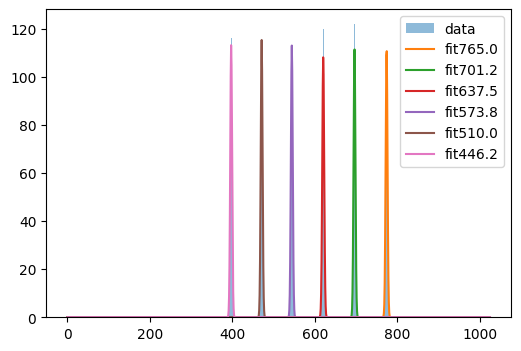

In [6]:
#ガウス分布を仮定して中心チャンネルを抽出するフィッティング。上記で入力した分布に対してフィットが行われる。
def sig(x, a, m, s):
    return a*np.exp(-0.5*(x-m)**2/s**2)

scaling_ch=713.91#うまく合わせるトリック
ch = []
dch = []
E = []

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x=np.arange(1,1025)
_ = ax.hist(x, bins=1024, weights=pulsar, range=(0, 1024), alpha=0.5, label='data')

for mean,pulsar_i in zip(means,pulsar_list):
    E=np.append(E,mean/scaling_ch*4.5)
    y=pulsar_i
    dy=np.where(y > 0, np.sqrt(y), 1.0)
    par_gaus, cov_gaus = curve_fit(sig, x, y, p0=(100, mean, dA),sigma=dy)
    perr_gaus = np.sqrt(np.diag(cov_gaus))
    mat = np.vstack((par_gaus,perr_gaus)).T
    df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
    print(mean,df)
    ch=np.append(ch,float(par_gaus[1]))
    dch=np.append(dch,float(perr_gaus[1]))
    print("{:3.2f} {:.3f} +/- {:.3f}".format(E[-1],ch[-1],dch[-1]))
    y = sig(x, *par_gaus)
    _ = ax.plot(x, y, '-', label='fit{:5.1f}'.format(mean))
plt.legend(loc='upper right')

In [113]:
#フィッティングせずにとりあえず目で読んだ値で進める場合。上記でフィッティングしている場合は不要。
ch=np.array([774,695,620,543])#適切な値に置き換える
dch=np.ones(ch.size)#誤差は1とする
E=np.array([2.4,2.2,2.0,1.8])#適切な値に置き換える（パルス波の高さの比率等）

得られた結果を直線フィットすると0 MeV相当のチャンネル数が得られます。

        Estimate  Std. error
Slope   0.005350    0.000029
Offset  0.695008    0.016371


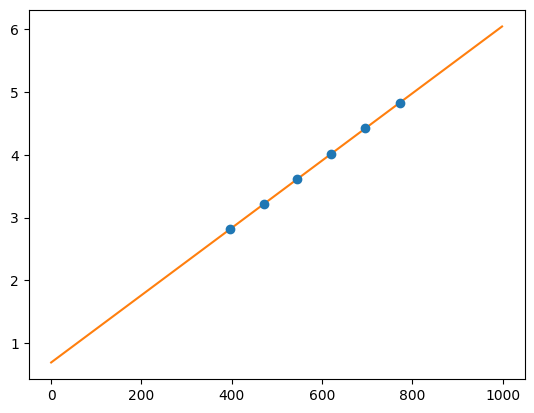

0 MeV= -129.91 +/-    3.14 ch


In [7]:
#中心チャンネルを結ぶよう直線フィッティングして、更に0 MeV相当のチャンネル数を算出。
def lin(x,a,b):
    return a*x+b

par_line, cov_line = curve_fit(lin, ch, E, sigma=dch)
perr_line = np.sqrt(np.diag(cov_line))
mat = np.vstack((par_line,perr_line)).T
df = pd.DataFrame(mat,index=("Slope", "Offset"), columns=("Estimate", "Std. error"))
print(df)

x_func = np.arange(0,1000)
y_func = par_line[0]*x_func + par_line[1]

plt.errorbar(ch,E,0,dch,fmt="o")
plt.plot(x_func,y_func)
plt.show()
E0=(0-par_line[1])/par_line[0]
dE0=abs((0-par_line[1])/par_line[0]*np.sqrt((perr_line[0]/par_line[0])**2+(perr_line[1]/par_line[1])**2))
print("0 MeV= {:7.2f} +/- {:7.2f} ch".format(E0,dE0))

続いてアルファ線が、途中標的を通過せずにセンサーに届いた場合の信号のチャンネル数を調べます。アルファ線のエネルギーが4.5 MeVであることを用いて、キャリブレーションのスケールを再決定します。

In [35]:
#シミュレーション用ダミー
Ealpha=800 #仮の中心値
dEalpha=25 #仮の幅

alpha_calib = np.random.normal(Ealpha, dEalpha, 5000)
alpha_calib, x = np.histogram(alpha_calib, range=(0, 1024), bins=1024)
#x=np.arange(1,1025)
#plt.plot(x, alpha_calib)

In [53]:
#実データ用。パスと名前は適宜書き換えること
alpha_calib = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/60sec0degNoTarget.csv', skip_footer=6)
#x=np.arange(1,1025)
#plt.plot(x, alpha_calib)

            Estimate  Std. error
Constant  168.058615    1.682813
Mean      713.914731    0.263170
Sigma      32.007574    0.188887
4.5 MeV=  713.91 +/-    0.26 ch
f(E4p5 [ch])= 4.514 +/- 0.026 [MeV]
f(E0 [ch])= 0.000 +/- 0.024 [MeV]


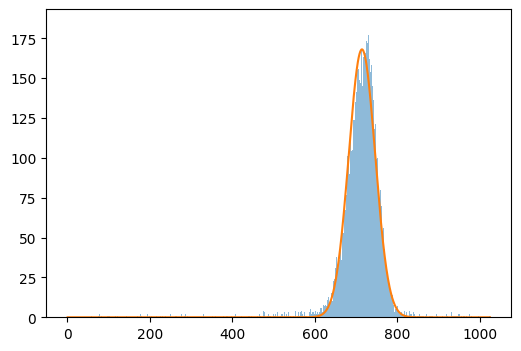

In [54]:
#ガウス分布でキャリブレーション用信号をフィッティングし、中心チャンネルを導出。
def dlin(x,a,b,dx,da,db):#直線フィッティング結果を用いて算出した値の誤差導出用関数
    dy=(x*da)**2
    dy+=(dx*a)**2
    dy+=db**2
    dy=np.sqrt(dy)
    #print("{:10.4f}, {:10.4f}, {:10.4f}".format((x*da),dx*a,db))
    return dy

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x=np.arange(1,1025)
_ = ax.hist(x, bins=1024, weights=alpha_calib, range=(0, 1024), alpha=0.5, label='data')
dy=np.where(alpha_calib > 0, np.sqrt(alpha_calib), 1.0)
par_calib, cov_calib = curve_fit(sig, x, alpha_calib, p0=(100, 800, 25), sigma=dy)
perr_calib = np.sqrt(np.diag(cov_calib))
mat = np.vstack((par_calib,perr_calib)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *par_calib)
_ = ax.plot(x, y, '-', label='fit_calib')
E4p5=par_calib[1]
dE4p5=perr_calib[1]
print("4.5 MeV= {:7.2f} +/- {:7.2f} ch".format(E4p5,dE4p5))

print("f(E4p5 [ch])= {:5.3f} +/- {:5.3f} [MeV]".format(lin(E4p5,par_line[0],par_line[1]),dlin(E4p5,par_line[0],par_line[1],dE4p5,perr_line[0],perr_line[1])))
print("f(E0 [ch])= {:5.3f} +/- {:5.3f} [MeV]".format(lin(E0,par_line[0],par_line[1]),dlin(E0,par_line[0],par_line[1],dE0,perr_line[0],perr_line[1])))


上記でそれぞれf(ch)の出力が誤差の範囲で意図したエネルギーを示していることを確認出来たら、以下ではこの関数をチャンネル数からエネルギーへの変換関数として用います。

続いて上記キャリブレーションに用いた同じデータを用いて線源の強度を計算します。また、ターゲットに入射する信号強度、ターゲットからセンサーへの見込み角も計算します。

In [72]:
#実験装置のジオメトリ・上記測定結果から各種計算

drs=6/2 #mm センサー手前のウィンドウ幅
Ss=np.pi*drs**2 #センサー手前のウィンドウ面積
L=130 #mm 線源からセンサーまでの距離
dOmega_RtoS=Ss/L**2 #線源からセンサーまでの見込み角
print("線源からセンサーまでの見込み角={:10.3e} [sr]".format(dOmega_RtoS))

Ncalib=np.sum(alpha_calib)
Tcalib=60#sec, 測定時間に適宜書き換え

B0=Ncalib/Tcalib*4*np.pi/dOmega_RtoS#線源強度
dB0=np.sqrt(Ncalib)/Tcalib*4*np.pi/dOmega_RtoS#線源強度誤差
#オプション課題：不感時間を考慮するとどうなるか検討する
print("測定回数 {:8.3e} -> 線源強度={:10.3e} +/- {:7.1e} [Bq]".format(Ncalib,B0,dB0))

drt=6/2 #mm ターゲット手前のウィンドウ幅
St=np.pi*drt**2 #センサー手前のウィンドウ面積
Lt=58.3 #mm 線源からターゲット手前のウィンドウまでの距離
dOmega_RtoT=St/Lt**2 #線源からターゲット手前のウィンドウまでの見込み角
#オプション課題：ターゲット手前のウィンドウの傾きを検討する
print("線源からターゲット手前のウィンドウまでの見込み角={:10.3e} [sr]".format(dOmega_RtoT))

B=B0*dOmega_RtoT/4/np.pi
dB=dB0*dOmega_RtoT/4/np.pi
print("ターゲットに入射する信号強度={:6.1f} +/- {:6.1f} [Bq]".format(B,dB))

Ls=58.3 #mm ターゲットから線源までの距離
dOmega_TtoS=Ss/Ls**2 #ターゲットから線源までの見込み角
print("ターゲットから線源までの見込み角={:10.3e} [sr]".format(dOmega_TtoS))

線源からセンサーまでの見込み角= 1.673e-03 [sr]
測定回数 1.438e+04 -> 線源強度= 1.800e+06 +/- 1.5e+04 [Bq]
線源からターゲット手前のウィンドウまでの見込み角= 8.319e-03 [sr]
ターゲットに入射する信号強度=1191.8 +/-    9.9 [Bq]
ターゲットから線源までの見込み角= 8.319e-03 [sr]


公称値2 MBqに対して測定された強度は妥当か検討してください。

続いて間に薄膜を挟んでその厚さ測定を行います。

In [19]:
#シミュレーション用ダミー
EAu=668 #仮の値
dEAu=25 #シミュレーション用
EAl=222 #仮の値
dEAl=50 #シミュレーション用

Aldeg0 = np.random.normal(EAl, dEAl, 5000)
Aldeg0, x = np.histogram(Aldeg0, range=(0, 1024), bins=1024)
Audeg0 = np.random.normal(EAu, dEAu, 5000)
Audeg0, x = np.histogram(Audeg0, range=(0, 1024), bins=1024)
deg0=Aldeg0+Audeg0

In [56]:
#実データ用。パスと名前は適宜書き換えること
Aldeg0 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/60sec0degAl.csv', skip_footer=6)
Audeg0 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/Au.csv', skip_footer=6)
deg0=Aldeg0+Audeg0

            Estimate  Std. error
Constant   63.122948    0.576837
Mean      230.809163    0.480026
Sigma      63.742315    0.356863
EAl :    1.930 +/-    0.018 MeV
            Estimate  Std. error
Constant  902.619797    8.408546
Mean      653.623923    0.328116
Sigma      41.678276    0.224012
EAu :    4.192 +/-    0.025 MeV


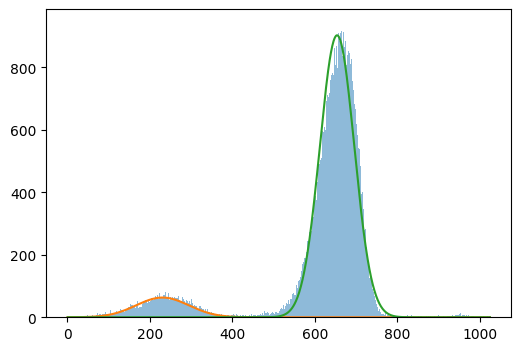

In [57]:
#上記で定義したAl, Auを通過したスペクトルをガウス分布でフィッティングする。

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x=np.arange(1,1025)
_ = ax.hist(x, bins=1024, weights=deg0, range=(0, 1024), alpha=0.5, label='data')

dy=np.where(Aldeg0 > 0, np.sqrt(Aldeg0), 1.0)
par_Al, cov_Al = curve_fit(sig, x, Aldeg0, p0=(50, EAl, dEAl), sigma=dy)
perr_Al = np.sqrt(np.diag(cov_Al))
mat = np.vstack((par_Al,perr_Al)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *par_Al)
_ = ax.plot(x, y, '-', label='fitAl')

EAlreco=lin(par_Al[1],par_line[0],par_line[1])
dEAlreco=dlin(par_Al[1],par_line[0],par_line[1],perr_Al[1],perr_line[0],perr_line[1])
print("EAl : {:8.3f} +/- {:8.3f} MeV".format(EAlreco,dEAlreco))

dy=np.where(Audeg0 > 0, np.sqrt(Audeg0), 1.0)
par_Au, cov_Au = curve_fit(sig, x, Audeg0, p0=(50, EAu, dEAu), sigma=dy)
perr_Au = np.sqrt(np.diag(cov_Au))
mat = np.vstack((par_Au,perr_Au)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *par_Au)
_ = ax.plot(x, y, '-', label='fitAu')

EAureco=lin(par_Au[1],par_line[0],par_line[1])
dEAureco=dlin(par_Au[1],par_line[0],par_line[1],perr_Au[1],perr_line[0],perr_line[1])
print("EAu : {:8.3f} +/- {:8.3f} MeV".format(EAureco,dEAureco))

続いてテキストにある理論曲線をフィットし、厚さとエネルギーの関係式を求めます。更にその関係式から各薄膜の厚さを計算します。

        Estimate  Std. error
Slope   4.542685    0.128205
Offset -2.285549    0.422323
Al残り飛程:       6.48 +/-       0.50 [um] -> 厚さdx=     12.14 +/-       0.50 [um]
        Estimate  Std. error
Slope   1.771394    0.038742
Offset -0.107500    0.127620
Au残り飛程:       7.32 +/-       0.21 [um] -> 厚さdx=      0.68 +/-       0.21 [um]


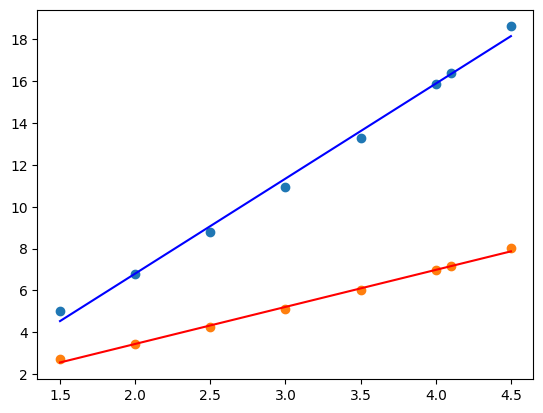

In [61]:
#厚さとエネルギーの関係式から、薄膜の厚さを求める

#テキストにある理論値
Ealphatheo=[1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.1, 4.5]
EAltheo=[5.017, 6.804, 8.777, 10.944, 13.308, 15.867, 16.402, 18.618]
EAutheo=[2.699, 3.435, 4.230, 5.086, 6.002, 6.974, 7.175, 8.001]

par_Al_line, cov_Al_line = curve_fit(lin, Ealphatheo, EAltheo)#アルファ線のエネルギー[MeV]->アルファ線が飛べるAlの厚さ[um]の式
perr_Al_line = np.sqrt(np.diag(cov_Al_line))
mat = np.vstack((par_Al_line,perr_Al_line)).T
df = pd.DataFrame(mat,index=("Slope", "Offset"), columns=("Estimate", "Std. error"))
print(df)
RAl=lin(EAlreco,par_Al_line[0],par_Al_line[1])#測定された、残りのエネルギーで飛べるAlの厚さ
dRAl=dlin(EAlreco,par_Al_line[0],par_Al_line[1],dEAlreco,perr_Al_line[0],perr_Al_line[1])#その誤差
dxAl=18.618-RAl#アルファ線が飛んできたAlの厚さ
print("Al残り飛程: {:10.2f} +/- {:10.2f} [um] -> 厚さdx={:10.2f} +/- {:10.2f} [um]".format(RAl,dRAl,dxAl,dRAl))
x_funcAl = np.arange(1.5,5.5)
y_funcAl = par_Al_line[0]*x_funcAl + par_Al_line[1]

#以下Auに関して同様
par_Au_line, cov_Au_line = curve_fit(lin, Ealphatheo, EAutheo)
perr_Au_line = np.sqrt(np.diag(cov_Au_line))
mat = np.vstack((par_Au_line,perr_Au_line)).T
df = pd.DataFrame(mat,index=("Slope", "Offset"), columns=("Estimate", "Std. error"))
print(df)
RAu=lin(EAureco,par_Au_line[0],par_Au_line[1])
dRAu=dlin(EAureco,par_Au_line[0],par_Au_line[1],dEAureco,perr_Au_line[0],perr_Au_line[1])
dxAu=8.001-RAu
print("Au残り飛程: {:10.2f} +/- {:10.2f} [um] -> 厚さdx={:10.2f} +/- {:10.2f} [um]".format(RAu,dRAu,dxAu,dRAu))
x_funcAu = np.arange(1.5,5.5)
y_funcAu = par_Au_line[0]*x_funcAu + par_Au_line[1]

#プロット用
plt.scatter(Ealphatheo,EAltheo,marker="o")
plt.scatter(Ealphatheo,EAutheo,marker="o")
plt.plot(x_funcAl,y_funcAl,'b',x_funcAu,y_funcAu,'r')

求められた厚さを公称値と比較してください。

測定値の推定

以上で装置のキャリブレーション・測定が完了しました。得られた値を基に、大角度の散乱現象の測定計画を立てます。ラザフォード散乱があることを再発見するためには、なるべく大角度での散乱事象を観測することが望ましいです。同時に、ターゲットを通過せずに直接センサーへ入射するバックグラウンド事象に対し、十分有意に大きな数の事象数を観測する必要があります。背景事象をいかに減らせるか、背景事象を信号事象からどれだけ正確に取り除けるか、そのうえで信号事象をいかに稼げるかが課題となります。仮にキャリブレーションに用いたデータを用いて背景事象の大まかな推測をし、それから研究計画を立てます。

オプション課題:小角度散乱の場合は多くの事象が期待されます。高精度で予測できるでしょうか？寄与の大きな誤差は？

In [113]:
print("<測定された数値>")
print("ターゲットに入射する信号強度={:6.1f} +/- {:6.1f} [Bq]".format(B,dB))
print("ターゲットから線源までの見込み角={:10.3e} [sr]".format(dOmega_TtoS))
print("Al厚さdx={:10.2f} +/- {:10.2f} [um]".format(dxAl,dRAl))
print("Au厚さdx={:10.2f} +/- {:10.2f} [um]".format(dxAu,dRAu))
upperCh=int(par_Al[1]+par_Al[2]*3)#3sigma
tcalib=60#sec
print(upperCh)
Bbg=np.sum(alpha_calib[:upperCh])/tcalib
print("元の背景事象強度{:10.1f}[Bq]".format(Bbg))
print("")

#def TestStat(b,s,ds,obs)
#    PDF=poisson.pmf(np.arange(obs*10), mu=b+s)
#    poisson(b+s)

#計画パラメタ
theta=50
t=3*24*60*60#sec
Rcut=1/4000#背景事象を削減するレート

print("測定時間{:10.0f}秒={:10.0f}分".format(t,t/60))
Nbg=t*Bbg*Rcut
print("推定背景事象数{:10.0f}".format(Nbg))
#PDF=poisson.pmf(np.arange(Nbg*5), mu=Nbg)


#計算用パラメタ
z = 2  # alpha は4He 2+
ZAl = 13  # Alの陽子数は13
ZAu = 79  # Auの陽子数は79
hbarc = 197.3
alpha = 1/137.
e2 = hbarc*alpha
E = 4.5

NA=6.02e23
Al_weight=26.98
Au_weight=196.97

#Al密度計算
NAl=dxAl*1e-4*2.69*NA/Al_weight #dxAl[cm]*2.69[g/cm^3]*NA[count/mol]/weight[g/mol]
dNAl=dRAl*1e-4*2.69*NA/Al_weight
print("単位面積当たりアルミニウム原子数={:10.1e} [1/cm^2]={:10.1e} [1/fm^2]".format(NAl,NAl*1e-26))
#Au密度計算
NAu=dxAu*1e-4*19.3*NA/Au_weight
dNAu=dRAu*1e-4*19.3*NA/Au_weight
print("単位面積当たり金原子数={:10.1e} [1/cm^2]={:10.1e} [1/fm^2]".format(NAu,NAu*1e-26))
print("")

#Al散乱確率計算
AAl = (z*ZAl*e2/4/E)**2
dsigmadOmegaAl=AAl*(np.sin(np.radians(theta)/2))**-4
print("dsigma/dOmega(Al)={:10.1e}[fm^2/sr]".format(dsigmadOmegaAl))

N_expectedAl=B*t*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS
dN_expectedAl=B*t*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAl)**2)+(dNAl/NAl)**2)
print("推定測定回数(Al)={:10.1e}+/-{:10.1e}".format(N_expectedAl,dN_expectedAl))
#print(np.sum(PDF[int(N_expectedAl):]),norm.ppf(1-np.sum(PDF[int(N_expectedAl):])))
print("")

#Au散乱確率計算
AAu = (z*ZAu*e2/4/E)**2
dsigmadOmegaAu=AAu*(np.sin(np.radians(theta)/2))**-4
print("dsigma/dOmega(Au)={:10.1e}[fm^2/sr]".format(dsigmadOmegaAu))

N_expectedAu=B*t*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS
dN_expectedAu=B*t*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAu)**2)+(dNAu/NAu)**2)
print("推定測定回数(Au)={:10.1e}+/-{:10.1e}".format(N_expectedAu,dN_expectedAu))


<測定された数値>
ターゲットに入射する信号強度=1191.8 +/-    9.9 [Bq]
ターゲットから線源までの見込み角= 8.319e-03 [sr]
Al厚さdx=     12.14 +/-       0.50 [um]
Au厚さdx=      0.68 +/-       0.21 [um]
422
元の背景事象強度       2.2[Bq]

測定時間    259200秒=      4320分
推定背景事象数       146
単位面積当たりアルミニウム原子数=   7.3e+19 [1/cm^2]=   7.3e-07 [1/fm^2]
単位面積当たり金原子数=   4.0e+18 [1/cm^2]=   4.0e-08 [1/fm^2]

dsigma/dOmega(Al)=   1.4e+02[fm^2/sr]
推定測定回数(Al)=   2.5e+02+/-   1.1e+01

dsigma/dOmega(Au)=   5.0e+03[fm^2/sr]
推定測定回数(Au)=   5.2e+02+/-   1.6e+02
